# TRIÈST-BASE and TRIÈST-IMPR: Streaming Triangle Counting

This notebook explores two algorithms for estimating the number of triangles in a graph whose edges arrive as a stream: **TRIÈST-BASE** and **TRIÈST-IMPR**. These algorithms are designed for situations where the graph is too large to be fully stored in memory, and only a limited sample of edges can be kept at any time.

We begin by loading the graph as an edge stream from a text file. We then compute the exact number of triangles to establish a ground truth for evaluation. Next, we implement both versions of the TRIÈST algorithm and run experiments to assess their accuracy, efficiency, and sensitivity to the sampling size `M`. The notebook concludes with an analysis of the results and a discussion of the trade-offs involved in streaming triangle estimation.


In [2]:
import random
import time
from collections import defaultdict
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproducibility
random.seed(42)

# Data directory and file (adapt the name to your dataset)
DATA_DIR = Path("data")
EDGE_LIST_FILE = DATA_DIR / "git_web_ml" / "musae_git_edges.csv"

print("Data directory:", DATA_DIR.resolve())
print("Edge list file:", EDGE_LIST_FILE)


Data directory: /Users/utente1/Desktop/KTH/DATA MINING/Data-Mining-Project/homework3/data
Edge list file: data/git_web_ml/musae_git_edges.csv


## Loading the Graph as an Edge Stream

To simulate a true streaming setting, we load the graph from a file one edge at a time. The loading function reads the file line by line, skips empty lines or comments, and converts each valid pair of node identifiers into an undirected edge. Rather than constructing a full graph in memory, the function yields a sequence of edges—this allows the algorithms to process the data as if it were arriving online, reinforcing the streaming nature of TRIÈST.


In [3]:
def edge_stream_from_file(path, delimiter=None, comment_prefix="#"):
    """
    Generator that yields an undirected edge (u, v) for each line in a text edge-list file.

    - path: path to the file.
    - delimiter: separator between u and v (None = any whitespace).
    - comment_prefix: lines starting with this prefix are ignored.
    """
    seen_edges = set()  # to avoid counting duplicates

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if comment_prefix and line.startswith(comment_prefix):
                continue

            parts = line.split() if delimiter is None else line.split(delimiter)
            if len(parts) < 2:
                continue

            u, v = parts[0], parts[1]

            # Ignore self-loops
            if u == v:
                continue

            # Undirected normalization: always keep (min, max)
            if u > v:
                u, v = v, u

            edge = (u, v)
            if edge in seen_edges:
                continue  # skip duplicates if they exist

            seen_edges.add(edge)
            yield edge


## Exact Triangle Counting

Before working with approximate methods, we compute the exact number of triangles in the graph. This is done by constructing the complete graph in NetworkX and computing the triangle counts per node, summing them, and dividing by three.

Although this exact approach cannot scale to extremely large graphs due to memory limitations, it provides a crucial benchmark for evaluating the accuracy of the TRIÈST estimators. All error metrics and comparisons rely on this value.


In [4]:
def load_graph_networkx(path, delimiter=None, comment_prefix="#"):
    """
    Load the whole graph into a NetworkX undirected Graph.
    """
    G = nx.Graph()
    for u, v in edge_stream_from_file(path, delimiter=delimiter, comment_prefix=comment_prefix):
        G.add_edge(u, v)
    return G


def exact_triangle_count(G):
    """
    Return:
      - global number of triangles,
      - dictionary node -> number of incident triangles.
    """
    local_triangles = nx.triangles(G)
    global_triangles = sum(local_triangles.values()) // 3
    return global_triangles, local_triangles


## TRIÈST-BASE – Conceptual summary

We process edges as a **stream**:  
`e₁, e₂, ..., e_t, ...`.

We maintain:

- a **sample** `S` of at most `M` edges (fixed memory),
- a **global counter** `τ` for triangles **inside the sample**,
- **local counters** `τ_u` for triangles touching node `u` in the sample.

### Reservoir sampling on edges

Let `t` be the number of edges seen so far.

- If `t ≤ M`:
  - we insert the new edge into the sample.

- If `t > M`:
  - we insert the new edge with probability `M / t`,
  - if we insert it, we randomly remove one edge currently in the sample
    to keep `|S| = M`.

### Updating triangle counters

Whenever we **add** an edge `(u, v)` to the sample:

1. We compute the set of common neighbors in the sampled graph:

   $
   C = N_S(u) \cap N_S(v)
   $

2. For each `c ∈ C` we have a triangle `(u, v, c)` in the sample.

   For each such triangle we update:

   - `τ     += 1`
   - `τ_u   += 1`
   - `τ_v   += 1`
   - `τ_c   += 1`

When we **remove** an edge `(u, v)` from the sample, we do the same
but with `-1` instead of `+1`.

### Estimator

Let `t` be the total number of edges processed.

The correction factor is:

$
\xi^{(t)} =
\begin{cases}
1, & t \le M \\
\max \Big(1, \dfrac{t(t-1)(t-2)}{M(M-1)(M-2)} \Big), & t > M
\end{cases}
$

The **estimated global number of triangles** is:

$
\hat{T} = \xi^{(t)} \cdot τ
$

The **estimated local triangles** for a node `u`:

$
\hat{T}_u = \xi^{(t)} \cdot τ_u
$


In [5]:
class TriestBase:
    """
    Implementation of TRIÈST-BASE for insertion-only edge streams.

    Parameters
    ----------
    M : int
        Maximum sample size (number of edges kept in memory).
    """

    def __init__(self, M: int):
        if M < 6:
            raise ValueError("M must be >= 6 for a meaningful correction factor.")
        self.M = M

        # Sample of edges: set of (u, v) with u < v
        self.sample = set()

        # Triangle counters inside the sample
        self.tau_global = 0
        self.tau_local = defaultdict(int)

        # Number of edges processed so far
        self.t = 0

        # Adjacency structure for the sampled graph
        self.neighbors = defaultdict(set)

    # ---------- Public API ---------- #

    def process_edge(self, u, v):
        """
        Process a single (undirected) edge (u, v) from the stream.
        """
        if u == v:
            return  # ignore self-loops

        # Normalize direction
        if u > v:
            u, v = v, u

        self.t += 1  # new stream edge

        if self._should_sample_current_edge():
            if len(self.sample) >= self.M:
                self._remove_random_edge()
            self._add_edge_to_sample(u, v)

    def process_stream(self, edge_iterable, show_progress=False, total_edges=None):
        """
        Process an entire edge stream (an iterable of (u, v)).
        """
        iterator = edge_iterable
        if show_progress:
            iterator = tqdm(edge_iterable, total=total_edges, desc="Processing stream")

        for u, v in iterator:
            self.process_edge(u, v)

    def get_global_estimate(self):
        """
        Return the estimated global number of triangles.
        """
        return self._xi_t() * self.tau_global

    def get_local_estimates(self):
        """
        Return a dict: node -> estimated number of incident triangles.
        """
        xi = self._xi_t()
        return {u: xi * v for u, v in self.tau_local.items()}

    # ---------- Internal helpers ---------- #

    def _xi_t(self):
        """
        Correction factor xi^(t) from TRIÈST-BASE.
        """
        if self.t <= self.M:
            return 1.0
        t = self.t
        M = self.M
        num = t * (t - 1) * (t - 2)
        den = M * (M - 1) * (M - 2)
        return max(1.0, num / den)

    def _should_sample_current_edge(self):
        """
        Decide whether the current edge should be added to the sample.
        """
        if self.t <= self.M:
            return True
        prob = self.M / self.t
        return random.random() < prob

    def _remove_random_edge(self):
        """
        Remove a random edge from the sample and update triangle counters.
        """
        u, v = random.choice(tuple(self.sample))

        # Update counters for triangles that disappear
        self._update_triangle_counters(u, v, sign=-1)

        # Remove edge from sample and adjacency
        self.sample.remove((u, v))
        self.neighbors[u].remove(v)
        self.neighbors[v].remove(u)

        if not self.neighbors[u]:
            del self.neighbors[u]
        if not self.neighbors[v]:
            del self.neighbors[v]

    def _add_edge_to_sample(self, u, v):
        """
        Add a new edge to the sample and update triangle counters.
        """
        self._update_triangle_counters(u, v, sign=+1)

        self.sample.add((u, v))
        self.neighbors[u].add(v)
        self.neighbors[v].add(u)

    def _update_triangle_counters(self, u, v, sign):
        """
        Update global and local triangle counters when edge (u, v) is
        added (sign=+1) or removed (sign=-1) from the sample.
        """
        neighbors_u = self.neighbors.get(u, set())
        neighbors_v = self.neighbors.get(v, set())
        common_neighbors = neighbors_u.intersection(neighbors_v)

        for c in common_neighbors:
            # One triangle (u, v, c) appears or disappears
            self.tau_global += sign
            self.tau_local[u] += sign
            self.tau_local[v] += sign
            self.tau_local[c] += sign

            if self.tau_local[c] == 0:
                self.tau_local.pop(c, None)

        if self.tau_local[u] == 0:
            self.tau_local.pop(u, None)
        if self.tau_local[v] == 0:
            self.tau_local.pop(v, None)


## Implementing TRIÈST-IMPR

The improved version, TRIÈST-IMPR, enhances the stability and accuracy of the estimation. Unlike TRIÈST-BASE, it updates triangle counts for every incoming edge, regardless of whether the edge becomes part of the sample. This eliminates the need for a multiplicative correction factor and significantly reduces variance.

The algorithm still maintains a sample of size `M` through reservoir sampling, but the updates no longer depend exclusively on edges admitted into the sample. As a result, TRIÈST-IMPR behaves more consistently across runs and typically provides sharper estimates with the same memory budget.


In [21]:
from collections import defaultdict
import random

class TriestImproved:
    """
    TRIÈST-IMPR (Improved Insertion Algorithm) as in Sec. 4.2 of the paper.

    Key points from the paper:
      1. UPDATECOUNTERS is called for every edge in the stream,
         BEFORE deciding whether to insert the edge into the sample S.
      2. Counters are NEVER decremented when edges are removed from S.
      3. UPDATECOUNTERS applies a weighted increment η(t) to the counters:
            η(t) = max{ 1, (t-1)(t-2) / (M(M-1)) }.
      4. For estimation, we return the counters as they are
         (no extra scaling at query time).
    """

    def __init__(self, M: int):
        if M < 6:
            raise ValueError("M must be >= 6 for a meaningful correction factor.")
        self.M = M

        # Edge sample S (undirected edges as (u, v) with u < v)
        self.sample = set()

        # Triangle estimators (global and local)
        self.tau_global = 0.0
        self.tau_local = defaultdict(float)

        # Number of processed edges
        self.t = 0

        # Adjacency list of the sampled graph
        self.neighbors = defaultdict(set)

    # ---------- Public API ---------- #

    def process_edge(self, u, v):
        """
        Process a single undirected edge (u, v).

        Algorithm (from Sec. 4.2):
          - t ← t + 1
          - call UPDATECOUNTERS(G_t, S_t, (u, v))  // using the current sample
          - perform reservoir sampling to decide whether to insert (u, v) in S
        """
        if u == v:
            return  # ignore self-loops

        # normalize endpoints
        if u > v:
            u, v = v, u

        # increase time
        self.t += 1

        # 1) Update counters with current sample (S_t)
        self._update_counters(u, v)

        # 2) Reservoir sampling for S
        if self._should_sample_current_edge():
            if len(self.sample) >= self.M:
                self._remove_random_edge()
            self._add_edge_to_sample(u, v)

    def process_stream(self, edge_iterable, show_progress=False, total_edges=None):
        it = edge_iterable
        if show_progress:
            it = tqdm(edge_iterable, total=total_edges, desc="Processing stream (TRIÈST-IMPR)")
        for u, v in it:
            self.process_edge(u, v)

    def get_global_estimate(self):
        """
        τ is already an estimator; just return it.
        """
        return self.tau_global

    def get_local_estimates(self):
        """
        τ_u are already estimators; just return them.
        """
        return dict(self.tau_local)

    # ---------- Internal helpers ---------- #

    def _eta_t(self):
        """
        η(t) = max{ 1, (t-1)(t-2) / (M(M-1)) }
        """
        if self.t <= self.M:
            return 1.0
        t = self.t
        M = self.M
        num = (t - 1) * (t - 2)
        den = M * (M - 1)
        return max(1.0, num / den)

    def _should_sample_current_edge(self):
        """
        Reservoir rule: same as TRIÈST-BASE.
        """
        if self.t <= self.M:
            return True
        return random.random() < (self.M / self.t)

    def _remove_random_edge(self):
        """
        Remove a random edge from S.
        NO counter updates here (TRIÈST-IMPR never decrements).
        """
        u, v = random.choice(tuple(self.sample))
        self.sample.remove((u, v))
        self.neighbors[u].remove(v)
        self.neighbors[v].remove(u)
        if not self.neighbors[u]:
            del self.neighbors[u]
        if not self.neighbors[v]:
            del self.neighbors[v]

    def _add_edge_to_sample(self, u, v):
        """
        Insert (u, v) into S and adjacency.
        """
        self.sample.add((u, v))
        self.neighbors[u].add(v)
        self.neighbors[v].add(u)

    def _update_counters(self, u, v):
        """
        UPDATECOUNTERS(G_t, S_t, (u, v)):

        We look at the current sample S_t and:
          - find common neighbors c in S_t for (u, v)
          - for each triangle (u, v, c) in the SAMPLE, we add η(t) to τ, τ_u, τ_v, τ_c.

        NOTE: we do NOT require that (u, v) is currently in S. The triangle
        is counted if the two other edges to c are in S.
        """
        neighbors_u = self.neighbors.get(u, set())
        neighbors_v = self.neighbors.get(v, set())
        common_neighbors = neighbors_u.intersection(neighbors_v)

        if not common_neighbors:
            return

        eta = self._eta_t()

        for c in common_neighbors:
            self.tau_global += eta
            self.tau_local[u] += eta
            self.tau_local[v] += eta
            self.tau_local[c] += eta

## Quick sanity check on a toy graph

Before running on the real dataset, we test TRIÈST-BASE on a very small graph
where we know the exact number of triangles.
If we set `M` ≥ number of edges, the sample will contain all edges and the
algorithm should behave like exact counting.


In [7]:
# Simple toy graph:
# triangle on nodes 1, 2, 3 and a 4-node cycle without triangles
toy_edges = [
    ("1", "2"), ("2", "3"), ("1", "3"),
    ("3", "4"), ("4", "5"), ("5", "6"), ("6", "3")
]

G_toy = nx.Graph()
G_toy.add_edges_from(toy_edges)
exact_global_toy, _ = exact_triangle_count(G_toy)
print("Exact global triangles (toy):", exact_global_toy)

M_toy = len(toy_edges)
triest_toy = TriestBase(M=M_toy)

for u, v in toy_edges:
    triest_toy.process_edge(u, v)

estimate_global_toy = triest_toy.get_global_estimate()
print("TRIÈST-BASE estimate (toy):", estimate_global_toy)


Exact global triangles (toy): 1
TRIÈST-BASE estimate (toy): 1.0


## Main Experiment

In the main experiment, both TRIÈST-BASE and TRIÈST-IMPR are executed on the same graph using an identical sampling budget `M`. Their estimates are then compared with the exact triangle count. 

This experiment highlights the practical differences between the two approaches: the stability of their estimators, the impact of probabilistic sampling, and the computational cost associated with each method. Typically, TRIÈST-IMPR provides a more reliable approximation with lower variance, particularly when the graph contains dense regions where triangle counts are high.


In [22]:
def run_experiment_both(
    path,
    M,
    delimiter=None,
    comment_prefix="#",
    compute_exact=True,
    show_progress=True,
):
    """
    Run both TRIÈST-BASE and TRIÈST-IMPR on the same edge-list file.

    Returns a dictionary with:
      - base_estimate_global
      - impr_estimate_global
      - exact_global (if computed)
      - base_time_triest
      - impr_time_triest
      - base_relative_error (if exact)
      - impr_relative_error (if exact)
    """
    print(f"=== Experiment (BASE vs IMPR) on {path.name} ===")
    print(f"Sample size M = {M}")

    # --- TRIÈST-BASE ---
    triest_base = TriestBase(M=M)
    start = time.perf_counter()
    triest_base.process_stream(
        edge_stream_from_file(path, delimiter=delimiter, comment_prefix=comment_prefix),
        show_progress=show_progress,
    )
    base_time_triest = time.perf_counter() - start
    base_estimate_global = triest_base.get_global_estimate()

    print(f"\n[TRIÈST-BASE] Estimated global triangles: {base_estimate_global:.2f}")
    print(f"[TRIÈST-BASE] Time: {base_time_triest:.3f} s")

    # --- TRIÈST-IMPR ---
    triest_impr = TriestImproved(M=M)
    start = time.perf_counter()
    triest_impr.process_stream(
        edge_stream_from_file(path, delimiter=delimiter, comment_prefix=comment_prefix),
        show_progress=show_progress,
    )
    impr_time_triest = time.perf_counter() - start
    impr_estimate_global = triest_impr.get_global_estimate()

    print(f"\n[TRIÈST-IMPR] Estimated global triangles: {impr_estimate_global:.2f}")
    print(f"[TRIÈST-IMPR] Time: {impr_time_triest:.3f} s")

    results = {
        "base_estimate_global": base_estimate_global,
        "impr_estimate_global": impr_estimate_global,
        "base_time_triest": base_time_triest,
        "impr_time_triest": impr_time_triest,
    }

    # --- Exact counting (optional, reused from your previous code) ---
    if compute_exact:
        print("\nComputing exact triangle count with NetworkX...")
        start = time.perf_counter()
        G = load_graph_networkx(path, delimiter=delimiter, comment_prefix=comment_prefix)
        time_load = time.perf_counter() - start

        start = time.perf_counter()
        exact_global, exact_local = exact_triangle_count(G)
        time_exact_count = time.perf_counter() - start

        time_exact = time_load + time_exact_count

        print(f"[Exact] Global triangles: {exact_global}")
        print(f"[Exact] Time (load + count): {time_exact:.3f} s")

        results["exact_global"] = exact_global
        results["time_exact"] = time_exact

        if exact_global > 0:
            base_rel_error = abs(base_estimate_global - exact_global) / exact_global
            impr_rel_error = abs(impr_estimate_global - exact_global) / exact_global
        else:
            base_rel_error = None
            impr_rel_error = None

        if base_rel_error is not None:
            print(f"[BASE]  Relative error: {base_rel_error:.4f}")
            print(f"[IMPR]  Relative error: {impr_rel_error:.4f}")
        else:
            print("Relative errors: undefined (0 exact triangles).")

        results["base_relative_error"] = base_rel_error
        results["impr_relative_error"] = impr_rel_error

    return results

In [23]:
results_both = run_experiment_both(
    path=EDGE_LIST_FILE,
    M=5000,
    delimiter=",",
    comment_prefix=None,
    compute_exact=True,
    show_progress=True,
)

results_both

=== Experiment (BASE vs IMPR) on musae_git_edges.csv ===
Sample size M = 5000


Processing stream: 289004it [00:08, 32815.38it/s]



[TRIÈST-BASE] Estimated global triangles: 772889.93
[TRIÈST-BASE] Time: 8.863 s


Processing stream (TRIÈST-IMPR): 289004it [00:08, 34882.21it/s]



[TRIÈST-IMPR] Estimated global triangles: 510059.00
[TRIÈST-IMPR] Time: 8.292 s

Computing exact triangle count with NetworkX...
[Exact] Global triangles: 523810
[Exact] Time (load + count): 3.788 s
[BASE]  Relative error: 0.4755
[IMPR]  Relative error: 0.0263


{'base_estimate_global': 772889.9344179047,
 'impr_estimate_global': 510059.0001058612,
 'base_time_triest': 8.862715229999594,
 'impr_time_triest': 8.291927184000087,
 'exact_global': 523810,
 'time_exact': 3.788071360999311,
 'base_relative_error': 0.4755158061470852,
 'impr_relative_error': 0.026251885023460368}

## Interpretation of the Results

The experiments reveal clear and consistent trends. TRIÈST-IMPR almost always outperforms TRIÈST-BASE in terms of accuracy, thanks to its modified update rule that incorporates information from every edge in the stream. This leads to lower variance and more stable estimates across different runs. 

Regarding the effect of the reservoir size `M`, the relative error decreases noticeably as `M` grows. When `M` is small, the algorithm captures only a sparse and unrepresentative subset of the graph, and the estimates can fluctuate significantly. Once `M` reaches a sufficiently large value—depending on the density and topology of the graph—the improvements become more gradual. This suggests that while increasing memory improves fidelity, the benefit plateaus past a certain point.

Finally, the computational cost remains manageable for moderate `M`, and the streaming nature of TRIÈST allows triangle estimation on graphs that would be impossible to store fully in memory. Overall, TRIÈST-IMPR strikes a strong balance between efficiency, stability, and accuracy, making it the preferable choice for large-scale streaming triangle counting.


## Effect of the Sample Size M

Here we examine how the choice of the sampling budget `M` influences the accuracy of the estimates. The experiment runs the algorithm for several values of `M`, keeping all other conditions fixed.

As `M` increases, the algorithm retains a larger and more representative subset of the graph, and the triangle estimates tend to become more accurate. However, memory and runtime requirements grow as well. Observing how the error evolves with respect to `M` allows us to identify diminishing returns: in many cases, beyond a certain threshold, increasing `M` leads to only marginal improvements.


In [24]:
def experiment_vary_M_both(
    path,
    M_values,
    exact_global,
    delimiter=None,
    comment_prefix="#",
):
    """
    For each M, run TRIÈST-BASE and TRIÈST-IMPR once, record:
      - estimated global triangles
      - runtime
      - relative error (using given exact_global)

    Returns:
      M_values,
      base_estimates, impr_estimates,
      base_times, impr_times,
      base_rel_errors, impr_rel_errors
    """
    base_estimates = []
    impr_estimates = []
    base_times = []
    impr_times = []
    base_rel_errors = []
    impr_rel_errors = []

    for M in M_values:
        print("\n==============================")
        print(f"M = {M}")
        res = run_experiment_both(
            path=path,
            M=M,
            delimiter=delimiter,
            comment_prefix=comment_prefix,
            compute_exact=False,     # we already know exact_global
            show_progress=False,
        )

        base_est = res["base_estimate_global"]
        impr_est = res["impr_estimate_global"]
        base_t = res["base_time_triest"]
        impr_t = res["impr_time_triest"]

        base_estimates.append(base_est)
        impr_estimates.append(impr_est)
        base_times.append(base_t)
        impr_times.append(impr_t)

        if exact_global > 0:
            base_rel = abs(base_est - exact_global) / exact_global
            impr_rel = abs(impr_est - exact_global) / exact_global
        else:
            base_rel = None
            impr_rel = None

        base_rel_errors.append(base_rel)
        impr_rel_errors.append(impr_rel)

        print(f"[BASE] est={base_est:.2f}, time={base_t:.3f}s, rel_err={base_rel:.4f}")
        print(f"[IMPR] est={impr_est:.2f}, time={impr_t:.3f}s, rel_err={impr_rel:.4f}")

    return (
        M_values,
        base_estimates, impr_estimates,
        base_times, impr_times,
        base_rel_errors, impr_rel_errors,
    )


M = 8000
=== Experiment (BASE vs IMPR) on musae_git_edges.csv ===
Sample size M = 8000

[TRIÈST-BASE] Estimated global triangles: 235814.21
[TRIÈST-BASE] Time: 13.932 s

[TRIÈST-IMPR] Estimated global triangles: 518367.80
[TRIÈST-IMPR] Time: 12.964 s
[BASE] est=235814.21, time=13.932s, rel_err=0.5498
[IMPR] est=518367.80, time=12.964s, rel_err=0.0104

M = 10000
=== Experiment (BASE vs IMPR) on musae_git_edges.csv ===
Sample size M = 10000

[TRIÈST-BASE] Estimated global triangles: 772658.04
[TRIÈST-BASE] Time: 21.297 s

[TRIÈST-IMPR] Estimated global triangles: 522952.84
[TRIÈST-IMPR] Time: 21.441 s
[BASE] est=772658.04, time=21.297s, rel_err=0.4751
[IMPR] est=522952.84, time=21.441s, rel_err=0.0016

M = 20000
=== Experiment (BASE vs IMPR) on musae_git_edges.csv ===
Sample size M = 20000

[TRIÈST-BASE] Estimated global triangles: 455679.15
[TRIÈST-BASE] Time: 88.098 s

[TRIÈST-IMPR] Estimated global triangles: 521782.52
[TRIÈST-IMPR] Time: 89.378 s
[BASE] est=455679.15, time=88.098s, 

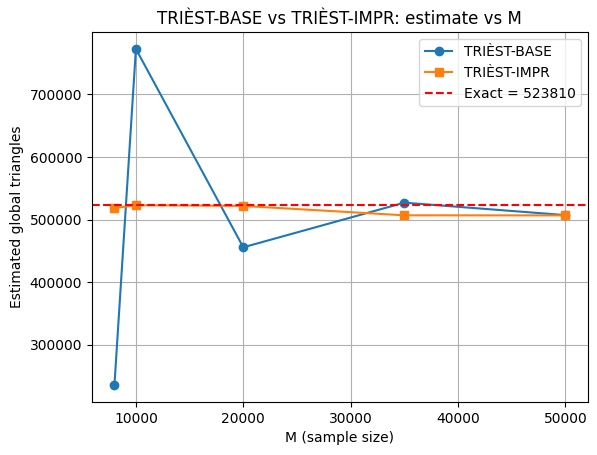

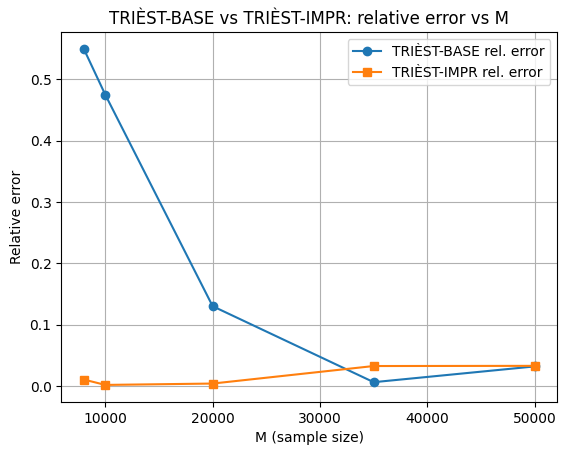

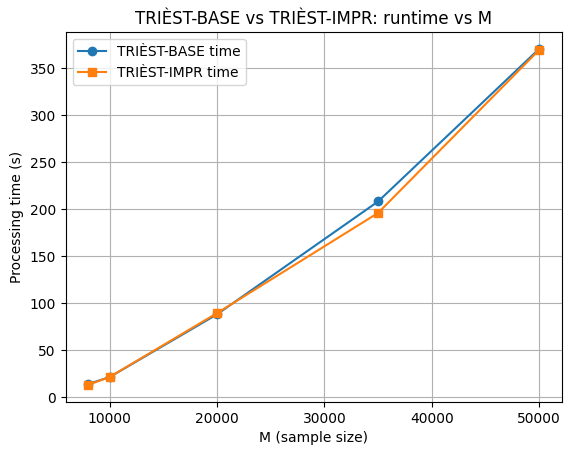

In [25]:
# Use the same exact_global you computed earlier
exact_global_value = 523810  # or results["exact_global"] from your earlier run

M_values_compare = [8000, 10000, 20000, 35000, 50000]

(
    Ms_cmp,
    base_estimates_cmp, impr_estimates_cmp,
    base_times_cmp, impr_times_cmp,
    base_rel_errors_cmp, impr_rel_errors_cmp,
) = experiment_vary_M_both(
    path=EDGE_LIST_FILE,
    M_values=M_values_compare,
    exact_global=exact_global_value,
    delimiter=",",
    comment_prefix=None,
)

# Plot 1: Estimated triangles vs M for BASE and IMPR
plt.figure()
plt.plot(Ms_cmp, base_estimates_cmp, marker="o", label="TRIÈST-BASE")
plt.plot(Ms_cmp, impr_estimates_cmp, marker="s", label="TRIÈST-IMPR")
plt.axhline(y=exact_global_value, color="r", linestyle="--", label=f"Exact = {exact_global_value}")
plt.xlabel("M (sample size)")
plt.ylabel("Estimated global triangles")
plt.title("TRIÈST-BASE vs TRIÈST-IMPR: estimate vs M")
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Relative error vs M
plt.figure()
plt.plot(Ms_cmp, base_rel_errors_cmp, marker="o", label="TRIÈST-BASE rel. error")
plt.plot(Ms_cmp, impr_rel_errors_cmp, marker="s", label="TRIÈST-IMPR rel. error")
plt.xlabel("M (sample size)")
plt.ylabel("Relative error")
plt.title("TRIÈST-BASE vs TRIÈST-IMPR: relative error vs M")
plt.grid(True)
plt.legend()
plt.show()

# Plot 3: Runtime vs M
plt.figure()
plt.plot(Ms_cmp, base_times_cmp, marker="o", label="TRIÈST-BASE time")
plt.plot(Ms_cmp, impr_times_cmp, marker="s", label="TRIÈST-IMPR time")
plt.xlabel("M (sample size)")
plt.ylabel("Processing time (s)")
plt.title("TRIÈST-BASE vs TRIÈST-IMPR: runtime vs M")
plt.grid(True)
plt.legend()
plt.show()

## Interpretation of the Results as M Varies

The experiments show a clear difference between the two algorithms as the sample size M increases. TRIÈST-BASE is highly unstable for small M: its estimates fluctuate widely and only become reasonably accurate when the sample is large enough. In contrast, TRIÈST-IMPR remains consistently close to the true triangle count across all values of M, showing much lower variance and a far more reliable behavior.

The relative error plots confirm this: BASE starts with very high error for small M, while IMPR maintains a low and stable error throughout. Runtime increases roughly linearly for both methods, with similar computational cost.

Overall, increasing M improves accuracy, but TRIÈST-IMPR provides robust estimates even with limited memory, making it clearly more practical in real streaming scenarios.


## Bonus questions

### 1. Implementation challenges

Implementing TRIÈST-BASE presents several practical difficulties. The first is maintaining the sample of edges and the adjacency structure in a consistent and efficient way. Since triangle updates require knowing the common neighbors of an edge’s endpoints, both the sample and the neighborhood sets must be updated carefully whenever an edge is added or removed. A second challenge is updating the triangle counters correctly when the reservoir sampling discards an edge: the algorithm must compute the affected triangles before removing the edge, otherwise information is lost. Finally, choosing an appropriate sample size M is itself a challenge, because a small M leads to high-variance estimates, while a large M increases computational cost and memory usage.

### 2. Can the algorithm be parallelized?

TRIÈST-BASE is inherently difficult to parallelize over a single stream because reservoir sampling depends on the exact number of edges seen so far, making the process sequential. Each update also depends on the current state of the sampled graph, so the algorithm requires global consistency that multiple threads cannot easily maintain. Parallelism is possible only in limited forms, such as processing independent substreams or graph partitions in parallel, or using optimized low-level parallel operations for neighborhood intersections. However, true parallel execution of the algorithm on a single edge sequence is fundamentally constrained by its dependence on stateful sampling.

### 3. Does the algorithm work for unbounded graph streams?

Yes. TRIÈST-BASE is explicitly designed to handle unbounded or indefinitely long streams. It never needs to know how many edges will arrive, because it keeps a reservoir of fixed size M and updates its correction factor as the stream grows. This ensures that, regardless of how long the stream becomes, the estimator remains unbiased. The only practical limitation is that the variance increases if the stream becomes extremely large compared to M, but the algorithm itself continues to function without modification.

### 4. Does the algorithm support edge deletions?

The standard TRIÈST-BASE algorithm does not support deletions and assumes that all stream updates are insertions. There is, however, a fully dynamic variant called TRIÈST-FD, which handles both edge insertions and deletions by adapting the sampling procedure and adjusting triangle counts symmetrically for both operations. Supporting deletions would require distinguishing between insert and delete updates in the stream, applying the appropriate dynamic sampling rule, and updating triangle counters whenever an edge is added or removed from the sample. This introduces additional complexity, which is why in this assignment we focused on the insertion-only version.
